<h1><font color='DarkBlue'>Предсказание цены дома на основе тренировочных данных (задача регрессии)</font><h1>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats

from matplotlib import pyplot as plt
from collections import Counter

<h2><font color='DarkCyan'>#1 Загрузка данных и анализ</font><h2>

1) **Загружаем тренировочный датасет и смотрим на пропущенные значения**

{'LotFrontage': 259, 'Alley': 1369, 'MasVnrType': 872, 'MasVnrArea': 8, 'BsmtQual': 37, 'BsmtCond': 37, 'BsmtExposure': 38, 'BsmtFinType1': 37, 'BsmtFinType2': 38, 'Electrical': 1, 'FireplaceQu': 690, 'GarageType': 81, 'GarageYrBlt': 81, 'GarageFinish': 81, 'GarageQual': 81, 'GarageCond': 81, 'PoolQC': 1453, 'Fence': 1179, 'MiscFeature': 1406}


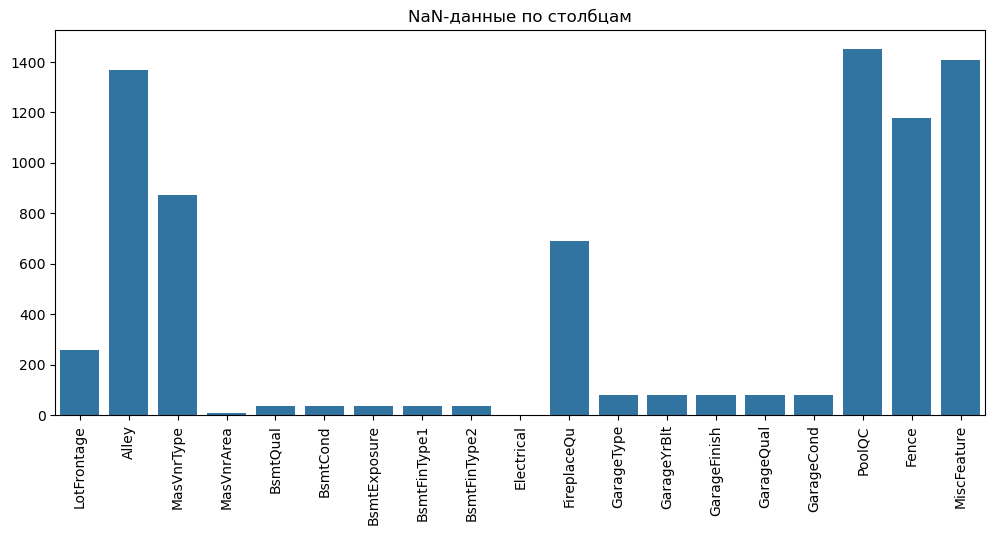

In [5]:
df = pd.read_csv('train.csv')

col_names = df.columns[1:]
nans = []
df_nan = df.isna()
cols = []
for col in col_names:
    howmuch = sum(df_nan[col])
    if (howmuch != 0):
        nans.append(howmuch)
        cols.append(col)

together = dict(zip(cols, nans))
print(together)
plt.figure(figsize=(12,5))
sns.barplot(data = together)
plt.xticks(rotation=90)
plt.title("NaN-данные по столбцам")
plt.show()

2. **Оказывается, есть несколько строчек, где неизвестный тип кладки, но при этом ненулевая ее площадь. Вряд ли признак "MasVnrType" ключевой, но все же будем считать эти данные бракованными и исключим их. Также имеется один экземпляр, где нет электричества. Тоже исключим его.**

In [7]:
#есть несколько ненулевых площадей при неизвестном типе. удаляем такие строки
check = df["MasVnrArea"][df_nan["MasVnrType"]].to_numpy()
ids = df['Id'][df_nan["MasVnrType"]].to_numpy(dtype=int)
indxs = []
for i in range(len(check)):
    if not np.isnan(check[i]) and check[i] != 0:
        indxs.append(True)
    else:
        indxs.append(False)

df.drop(index=ids[indxs]-1, axis=0, inplace=True)

#удаляем дом без электричества
electric = df['Electrical'].isna()
if sum(electric) > 0:
    df.drop(index=df['Electrical'][electric].index[0], axis=0, inplace=True)

df_nan = df.isna()
print(df_nan.shape)

(1454, 81)


3. **Сделаем так. Отсутсвующие данные в категориальных признаках отнесем к классу отсутствия "NOT". В числовых признаках "LotFrontage" и "GarageYrBlt" отсутствующие данные заполним медианными значениями. В остальных признаках просто поставим 0 на отсутствующих позициях.**

In [9]:
df["Alley"] = df["Alley"].fillna("NOT")
df["LotFrontage"] = df["LotFrontage"].fillna(df["LotFrontage"].median())
df["MasVnrType"] = df["MasVnrType"].fillna("NOT")
df["MasVnrArea"] = df["MasVnrArea"].fillna(0)
df["BsmtQual"] = df["BsmtQual"].fillna("NOT")
df["BsmtCond"] = df["BsmtCond"].fillna("NOT")
df["BsmtExposure"] = df["BsmtExposure"].fillna("NOT")
df["BsmtFinType1"] = df["BsmtFinType1"].fillna("NOT")
df["BsmtFinType2"] = df["BsmtFinType2"].fillna("NOT")
df["FireplaceQu"] = df["FireplaceQu"].fillna("NOT")
df["GarageType"] = df["GarageType"].fillna("NOT")
df["GarageFinish"] = df["GarageFinish"].fillna("NOT")
df["GarageQual"] = df["GarageQual"].fillna("NOT")
df["GarageCond"] = df["GarageCond"].fillna("NOT")
df["PoolQC"] = df["PoolQC"].fillna("NOT")
df["Fence"] = df["Fence"].fillna("NOT")
df["MiscFeature"] = df["MiscFeature"].fillna("NOT")
df["GarageYrBlt"] = df["GarageYrBlt"].fillna(df["GarageYrBlt"].median())

train_data = df
del df

4. **Выпишем числовые и категориальные признаки.**

In [11]:
numeric_cols = train_data.select_dtypes(include='number').columns[1:]
categorical_cols = train_data.select_dtypes(include=['object']).columns

<h3>Численные классы<h3> 
    
       'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'

<h3>Категориальные классы<h3> 
    
       'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'


5. **А теперь построим "ящики с усами" для числовых призаков.**

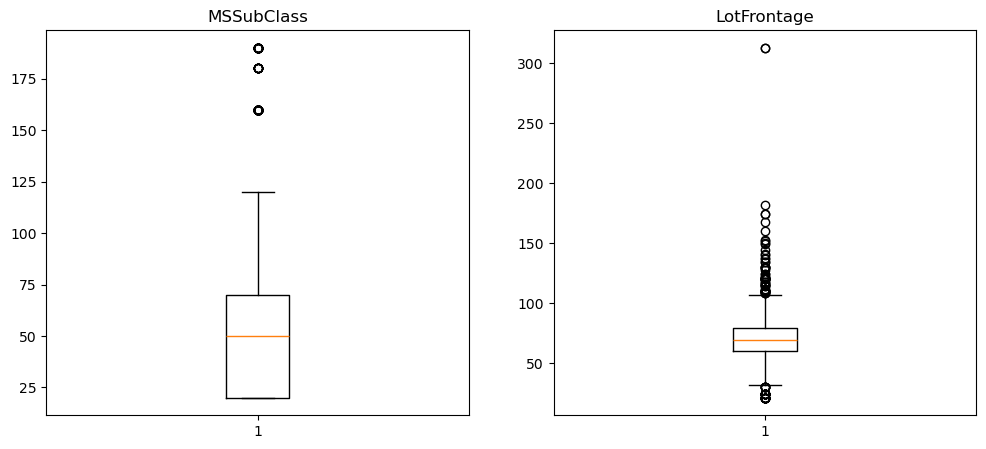

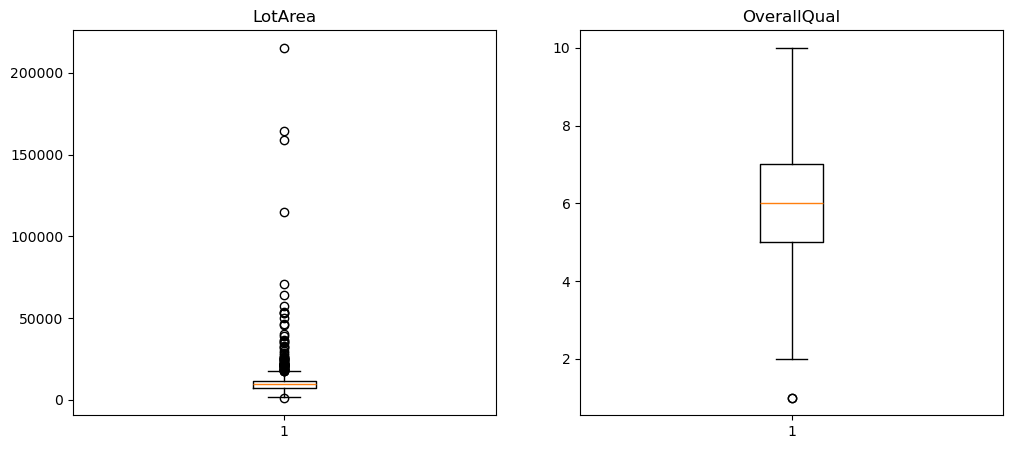

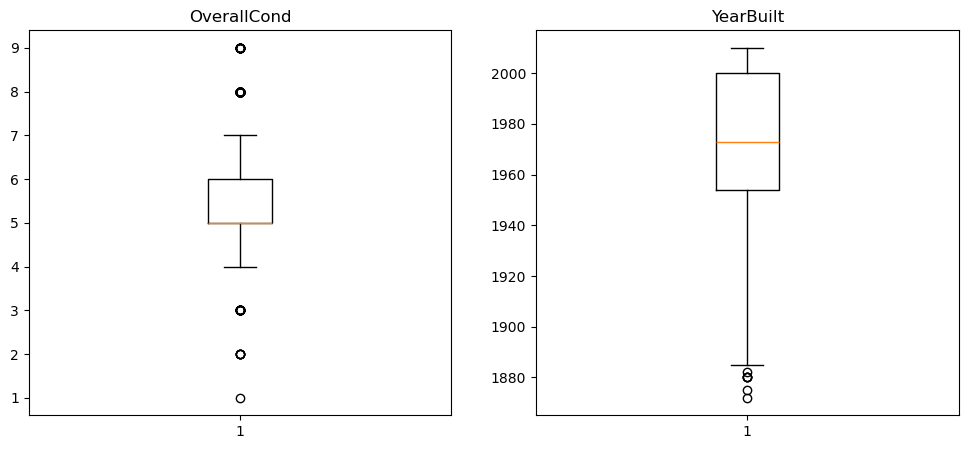

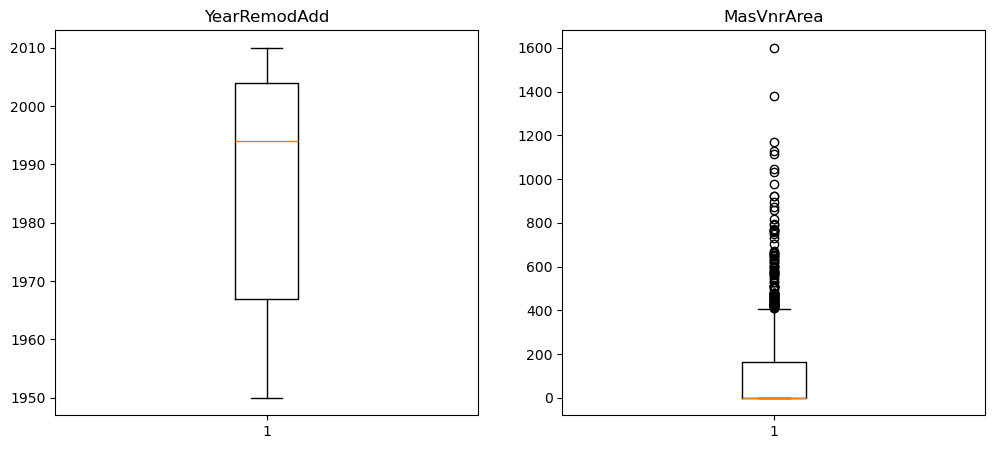

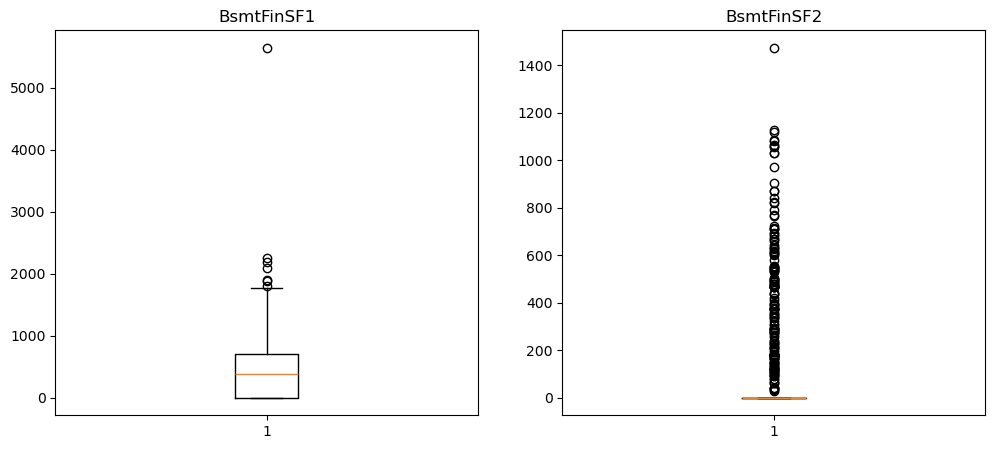

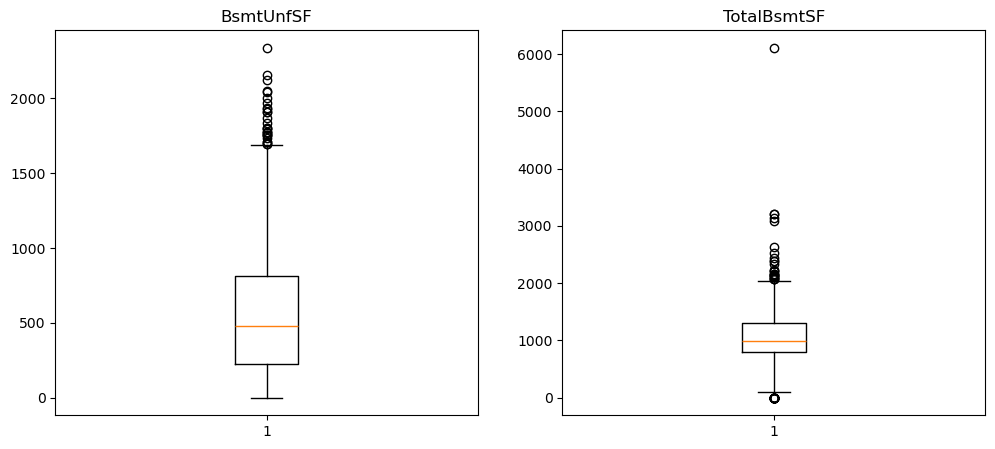

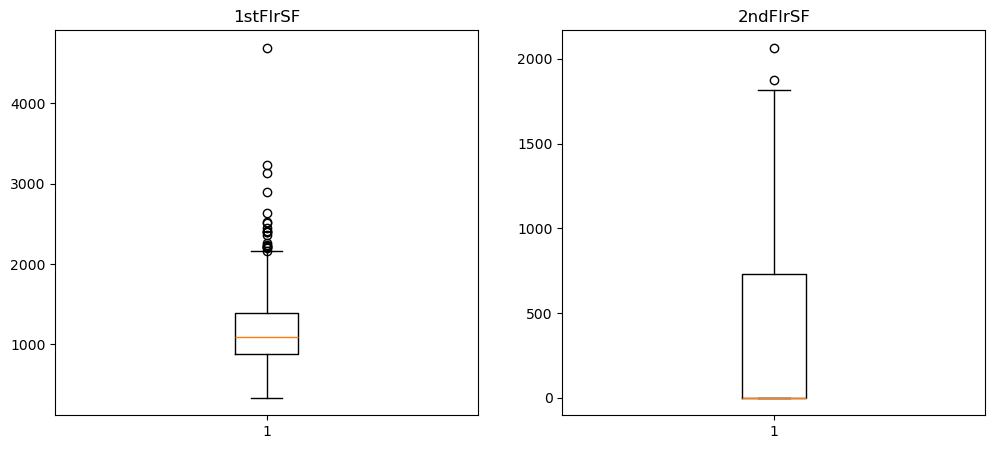

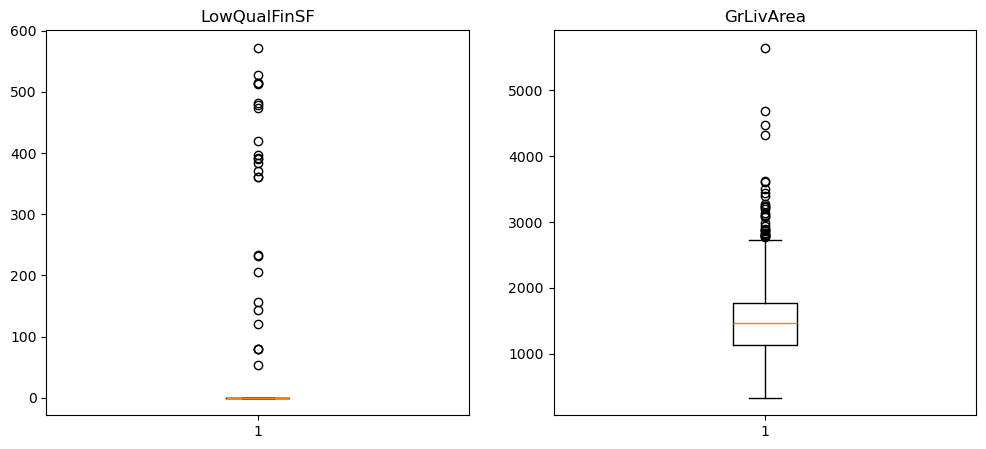

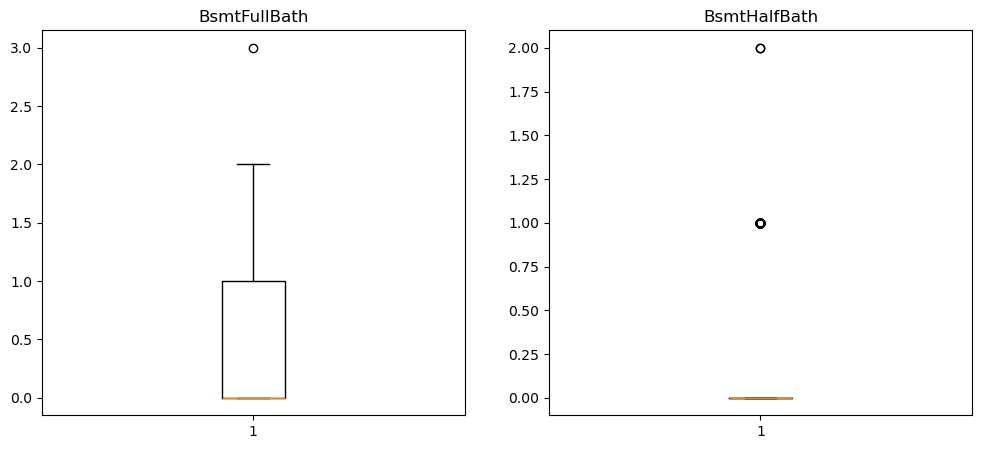

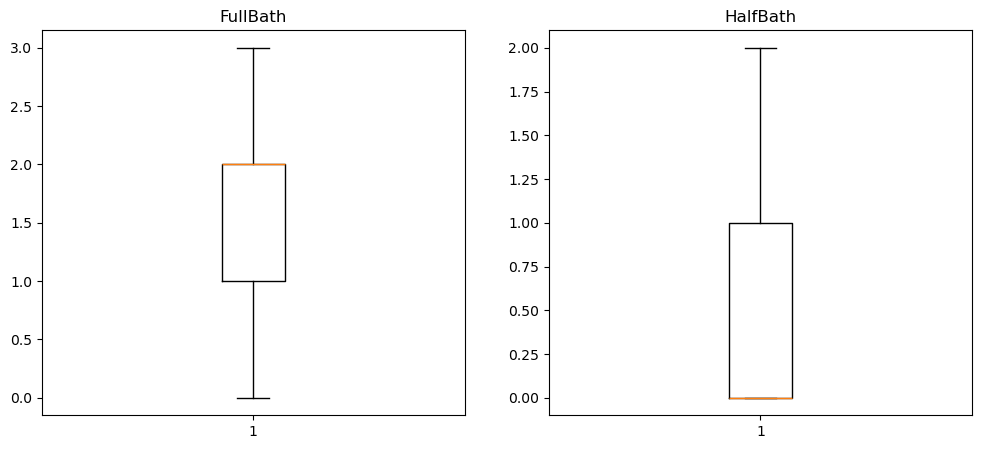

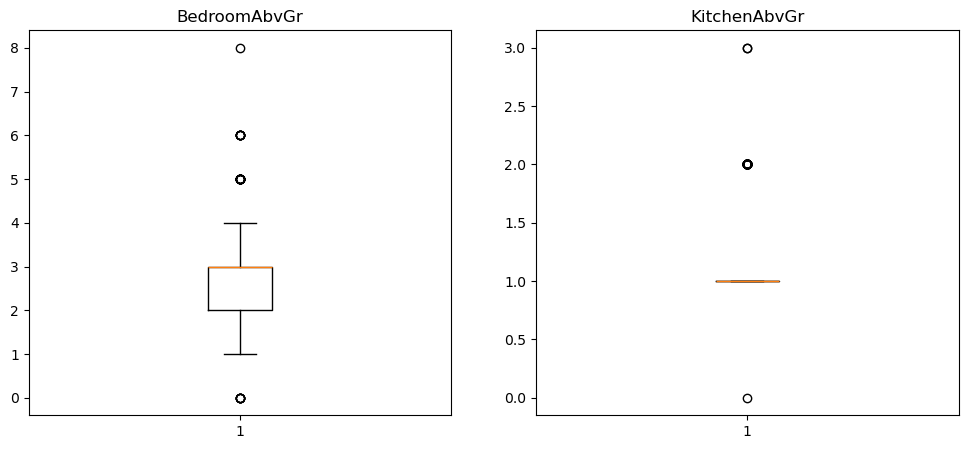

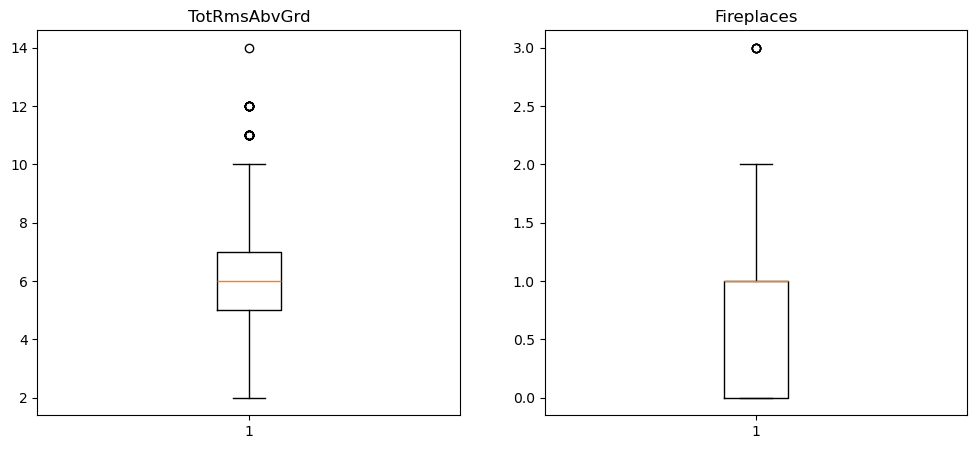

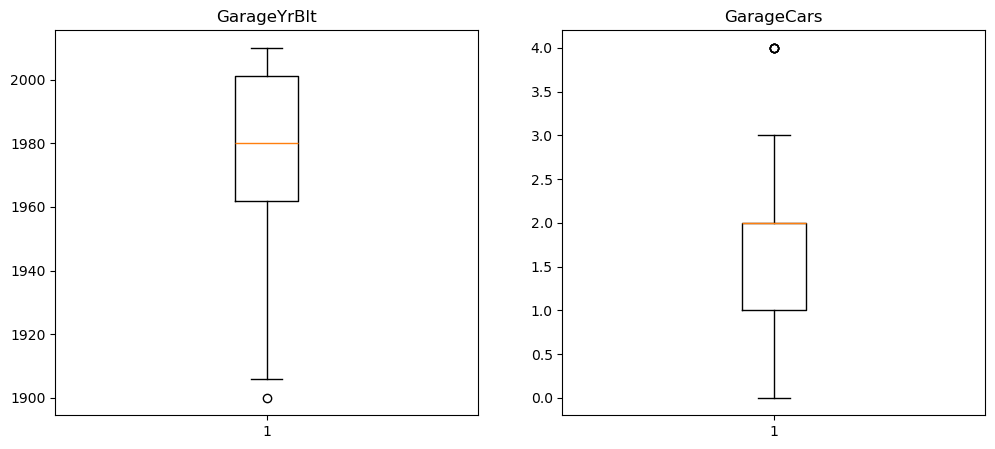

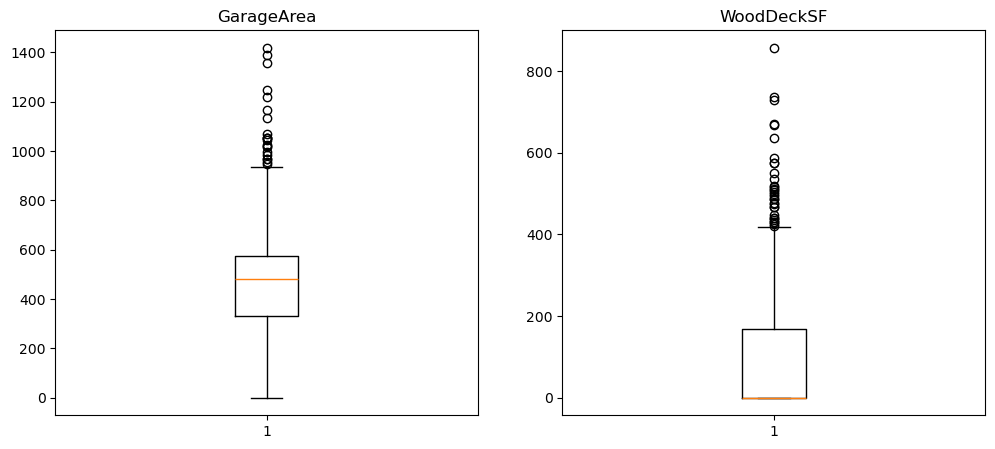

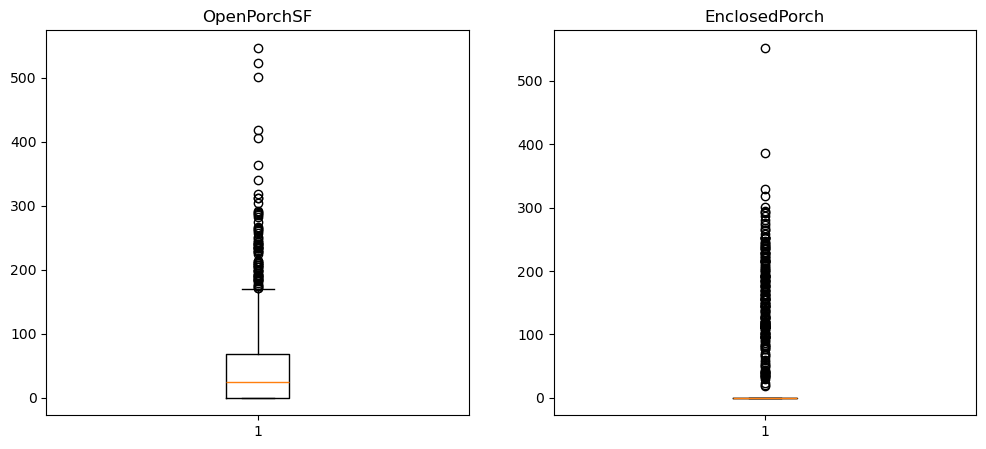

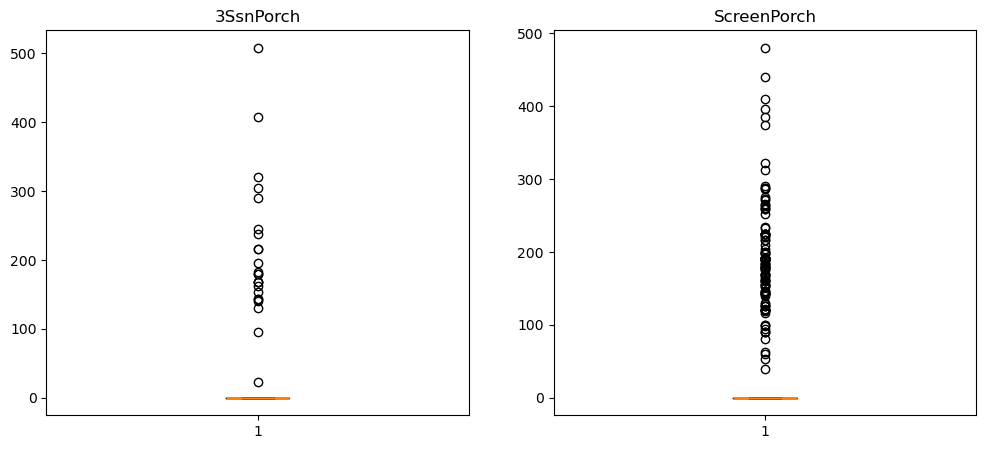

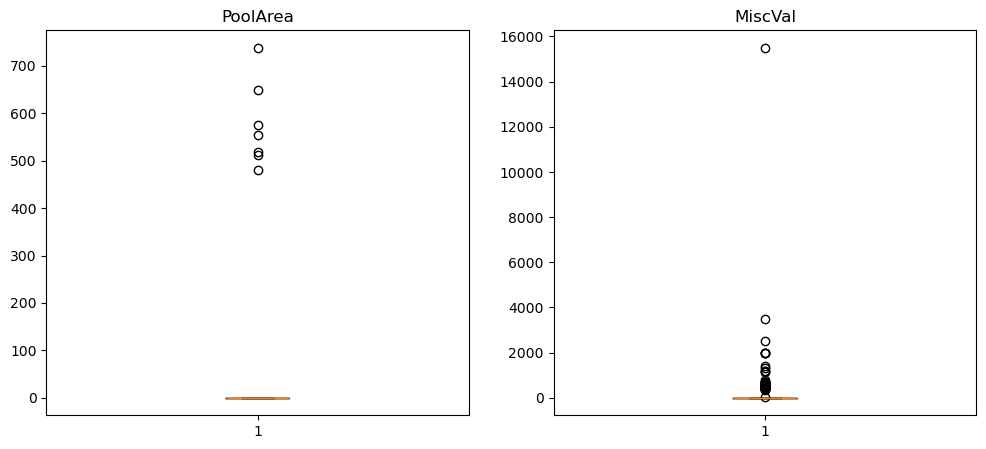

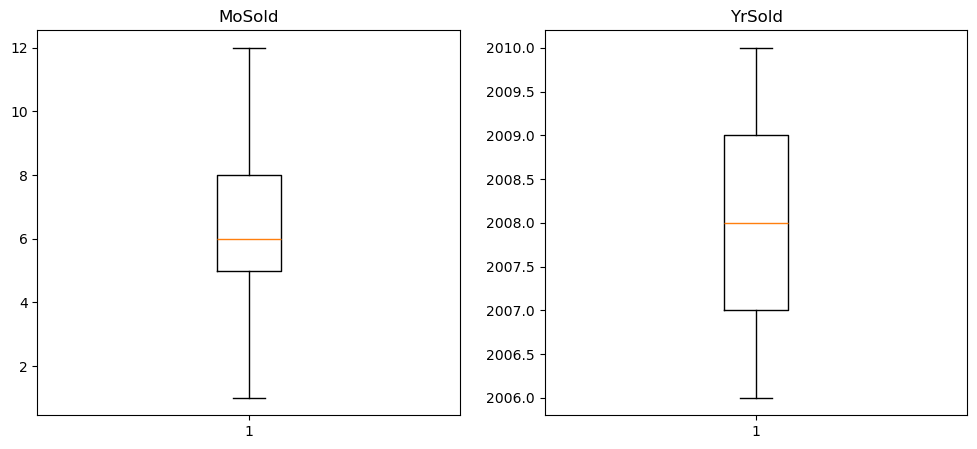

'for col in numeric_cols:\n    plt.boxplot(df[col])\n    plt.title(col)\n    plt.show()'

In [13]:
counter = 0
for j in range(len(numeric_cols)//2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    ax[0].boxplot(train_data[numeric_cols[counter]])
    ax[0].set_title(numeric_cols[counter])
    counter += 1
    ax[1].boxplot(train_data[numeric_cols[counter]])
    ax[1].set_title(numeric_cols[counter])
    plt.show()
    counter += 1

"""for col in numeric_cols:
    plt.boxplot(df[col])
    plt.title(col)
    plt.show()"""

6. **Видно, что многие велчиины имеют большое количество выходящих за "усы" значений. Однако, это не повод их убирать. Мы посмотрим позже, с какими признаками наиболее сильно коррелирует цена дома и уже там проведем фильтрацию некоторых экземпляров.**

7. **Также построим круговые диаграммы для категориальных признаков. Видим, что некоторые признаки имеют одно преобладающее значение, в то время как доля других значений пренебрежимо мала. В дальнейшем нам это пригодится.**

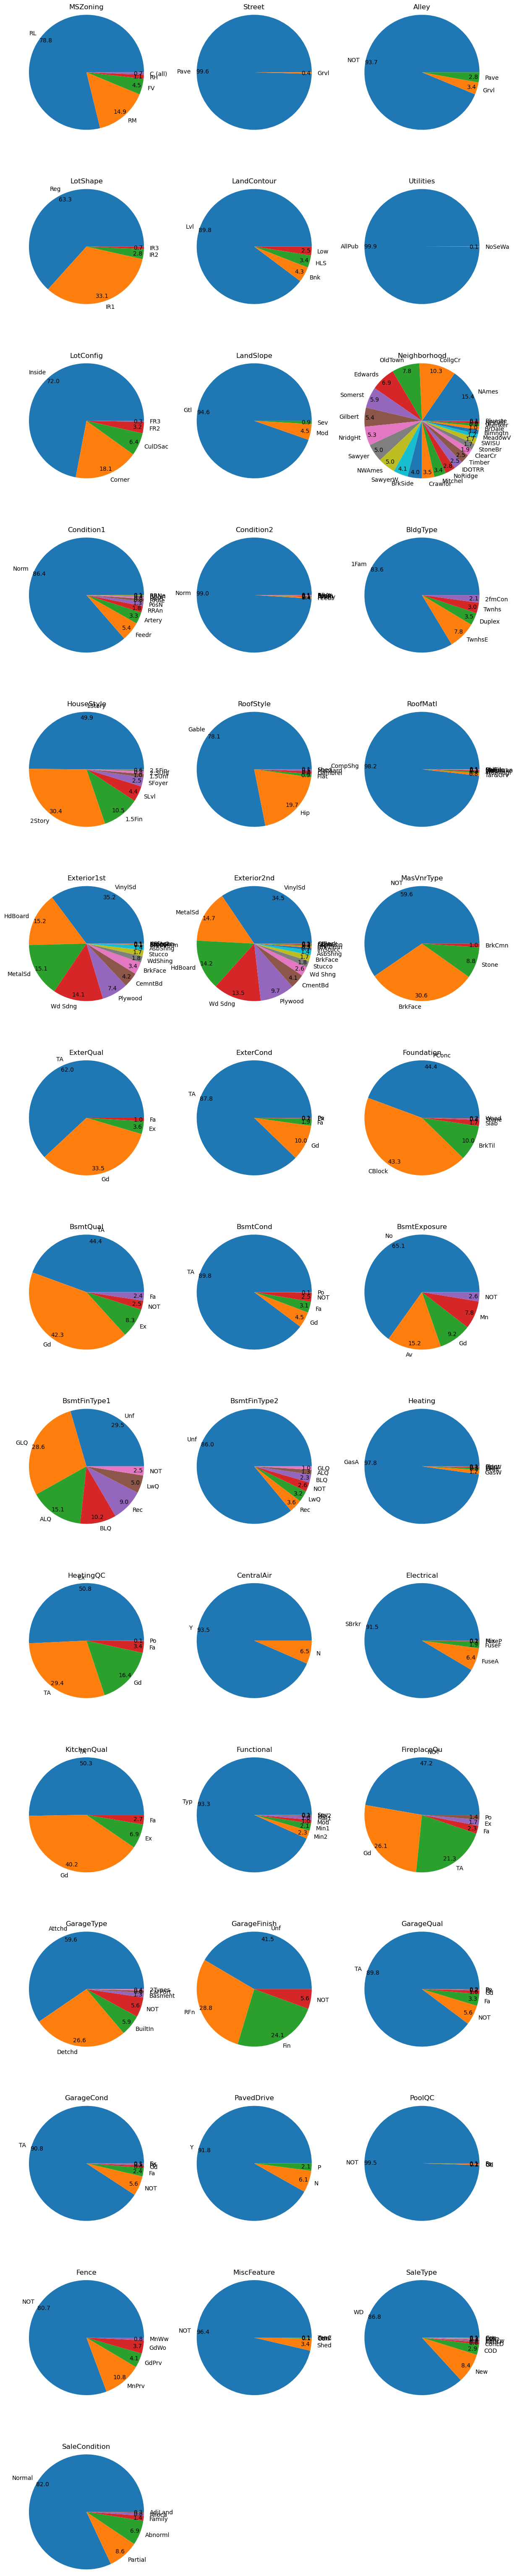

In [15]:
plt.figure(figsize=(14,80))
plt.subplots_adjust(wspace=0.4)
for i in range(1,len(categorical_cols)+1):
    distrib = train_data[categorical_cols[i-1]].value_counts()
    plt.subplot(len(categorical_cols)//3+1, 3, i)
    plt.pie(distrib, labels=distrib.axes[0], autopct='%.1f', pctdistance=0.9, labeldistance=1.1, radius=1.2) 
    plt.title(categorical_cols[i-1])
plt.show()

<h2><font color='DarkCyan'>#2 Фильтрация</font><h2>

8. **Теперь приступим к фильтрации. Для этого построим корреляционную матрицу и выберем наиболее существенные признаки.**

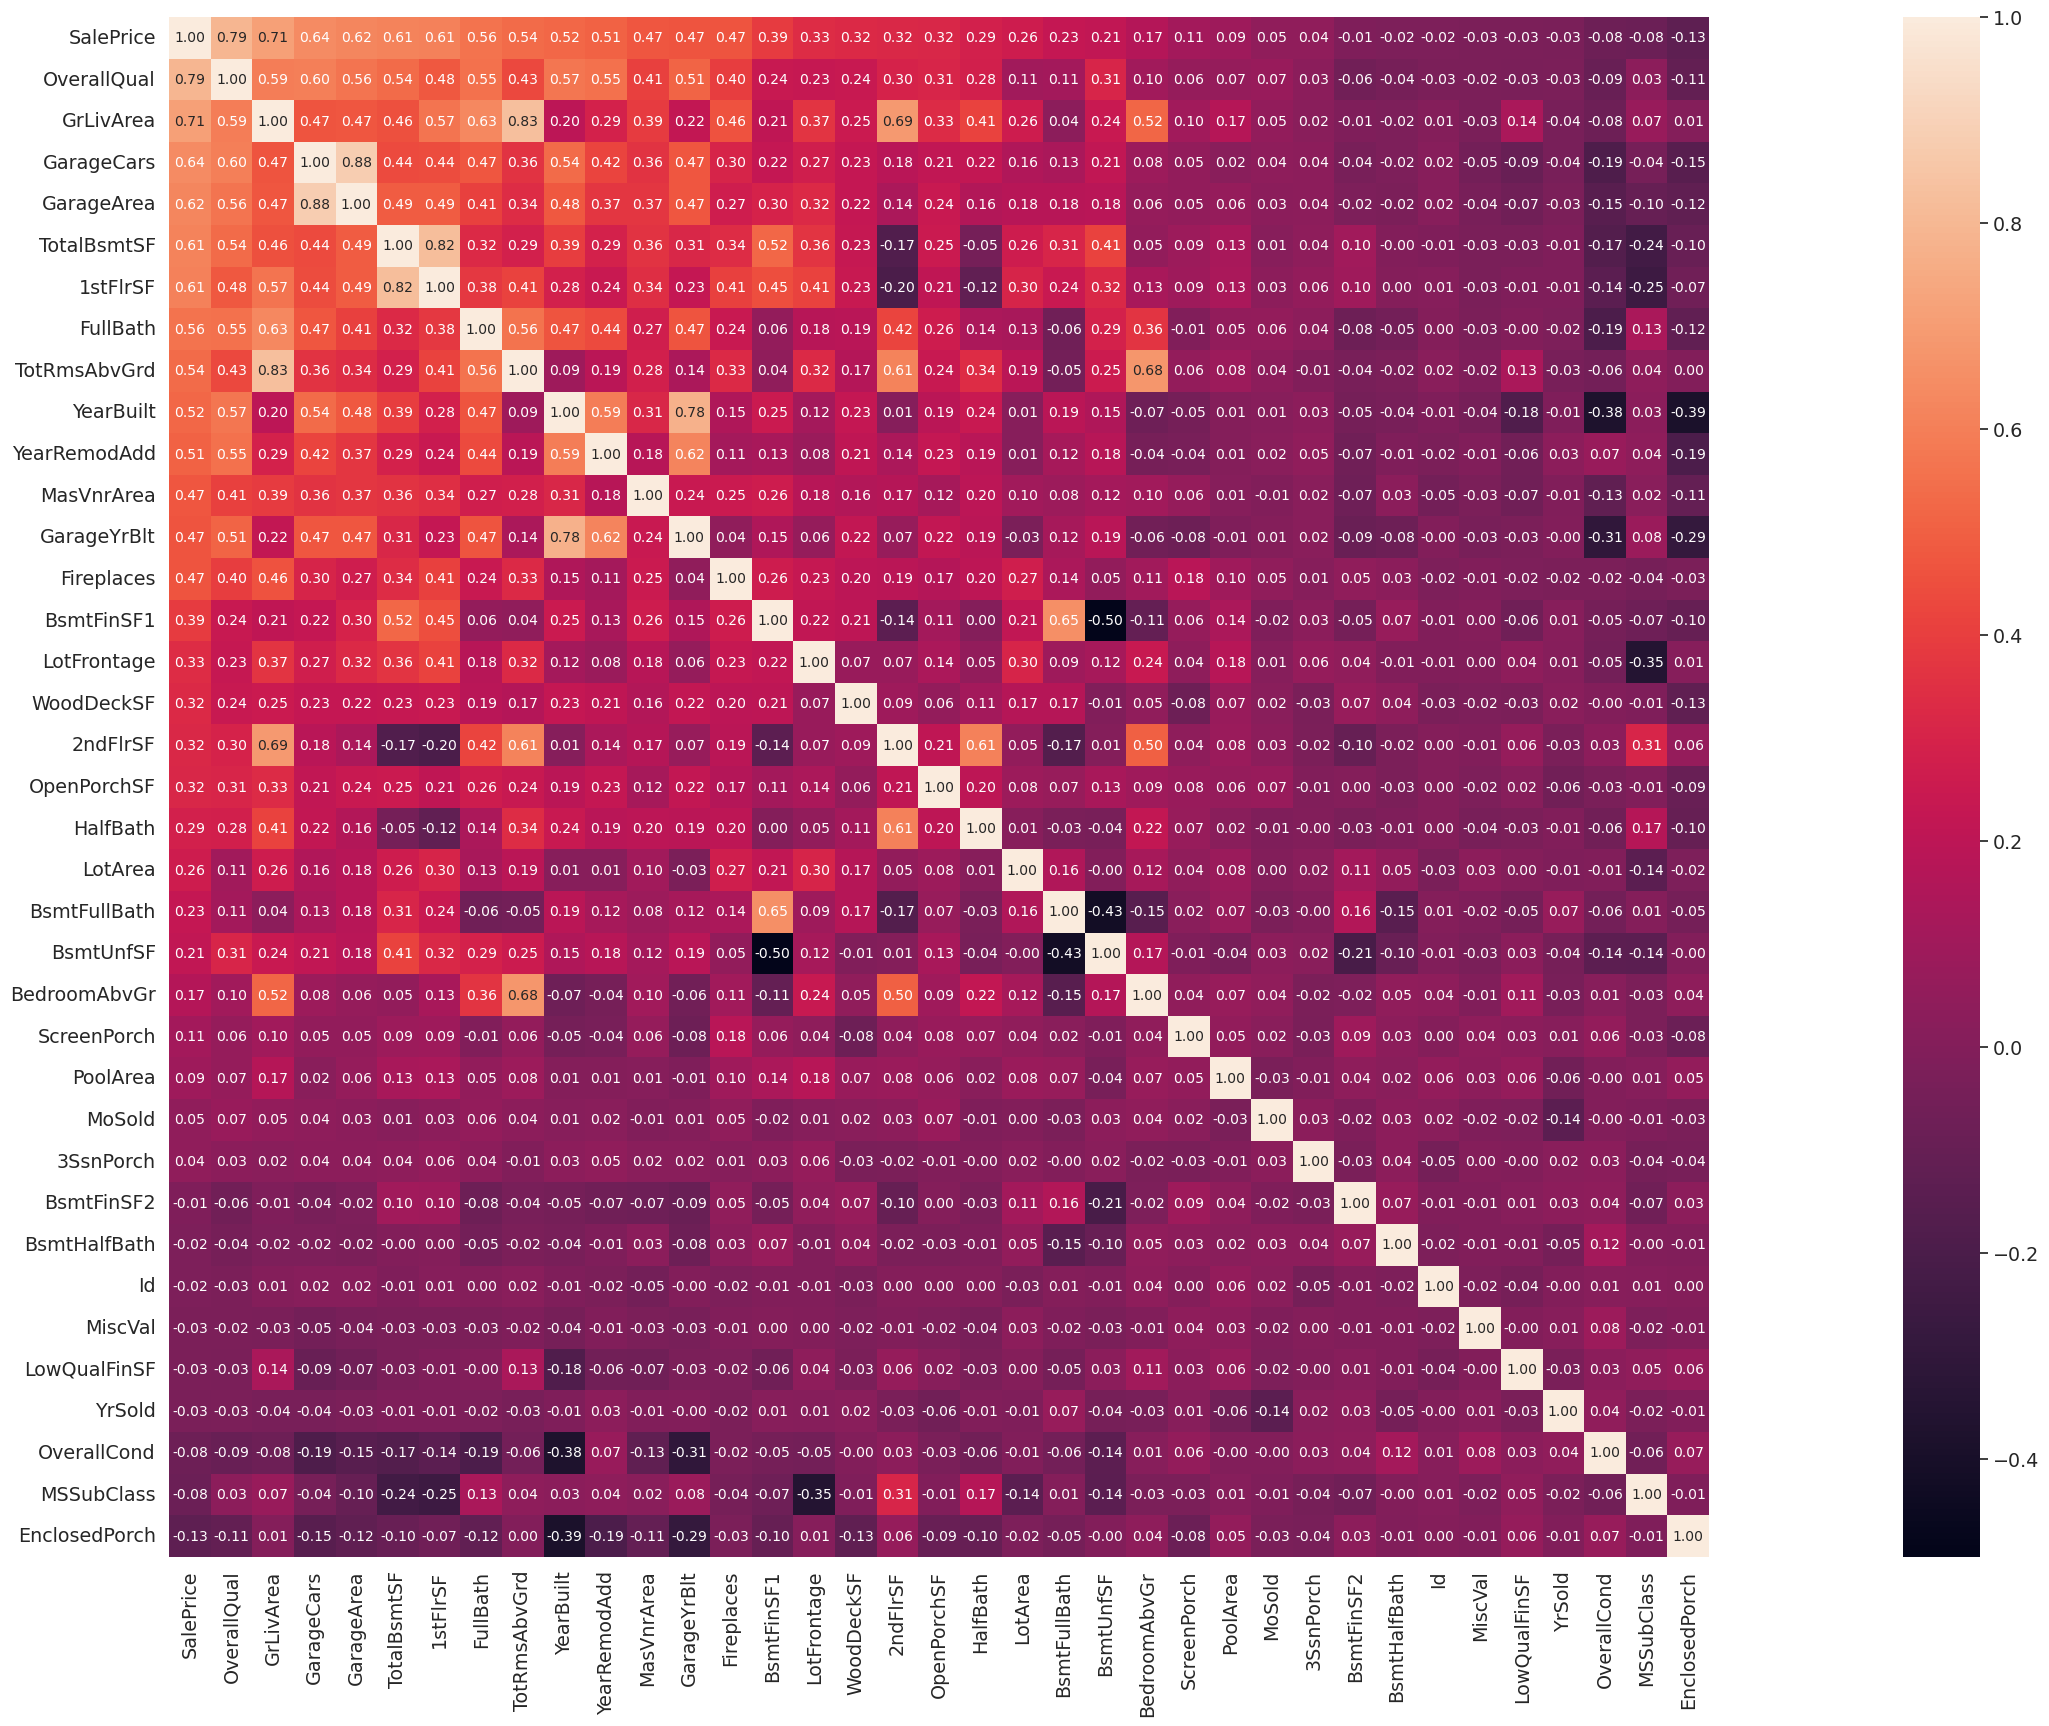

In [17]:
corrmat = train_data.select_dtypes(include='number').corr(numeric_only=False)
k = len(numeric_cols) #number of variables for heatmap
corr_col = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_data[corr_col].values.T)
plt.figure(figsize=(50,20))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=corr_col.values, xticklabels=corr_col.values)
plt.show()

9. **Берем те признаки, для которых коэффиицент корреляции больше 0.5. Вот они слева направо:**


          'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 
          '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd'

In [19]:
corrcol = corr_col.to_list()[1:11]

10. **Первый признак: общее качество. С ростом качества растет и стоимость, как оно и должно быть.**

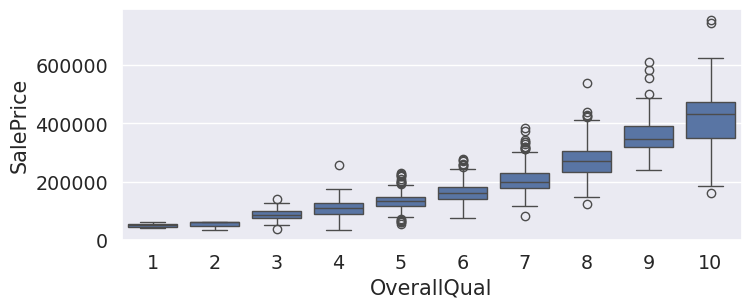

In [22]:
plt.figure(figsize=(8,3))
sns.boxplot(x=train_data[corrcol[0]], y=train_data['SalePrice'])
plt.show()

**Но в 10 классе есть признаки, которые при высоком качестве подозрительно низки в цене. Возможно, здесь жил известный филантроп Уоррен Баффет, дом отделан на 10/10, но продать дорого у него не поднялась рука. Однако, филантропы скорее исключение. Так что исключим их.**

In [25]:
print(train_data.shape)
train_data.drop(train_data[(train_data[corrcol[0]]==10) & (train_data['SalePrice']<200000)].index, inplace=True)
print(train_data.shape)

(1454, 81)
(1452, 81)


11. **Второй признак: 'GrLivArea' - площадь жилья. Тут нет значительных отклонений**

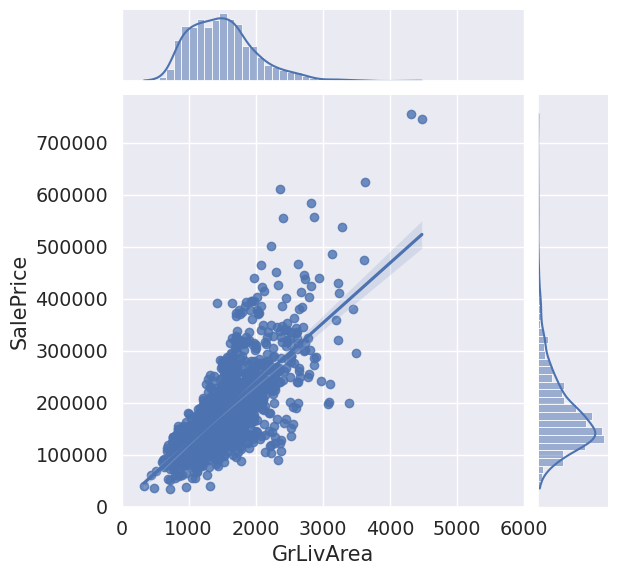

In [385]:
sns.jointplot(x=train_data[corrcol[1]], y=train_data['SalePrice'], kind='reg', xlim=(0, 6000))

12. **Третий признак: количество машин в гараже.**

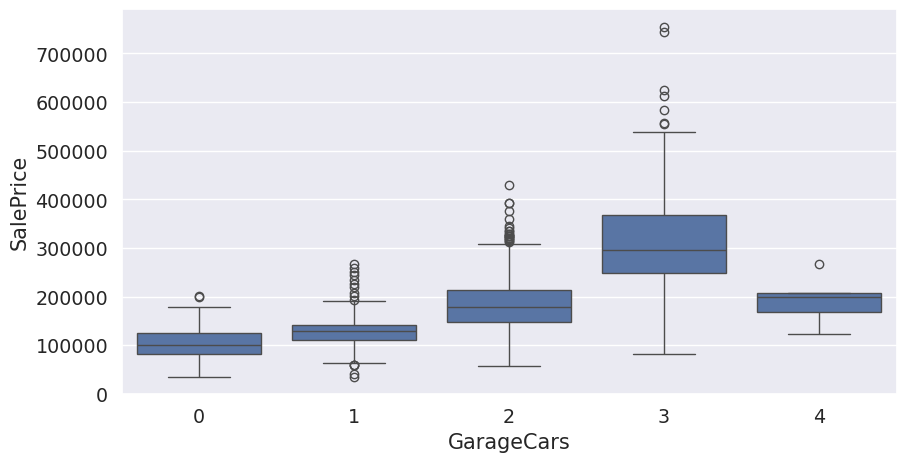

In [197]:
plt.figure(figsize=(10,5))
sns.boxplot(x=train_data[corrcol[2]], y=train_data['SalePrice'])
plt.show()

**Цена домов с 4 машинами находится на уровне не выше стоимости домов с 3 машинами. Возможно, здесь жил Стив Джобс, который, как известно, начал свой славный путь в гараже, а под машинами он подразумевал свои макинтоши, потому в декларациях и возникло такое недоразумение. Но макинтоши давно переименовали в маки, так что первые больше не котируются, удаляем все экземпляры с 4 машинами.**

In [28]:
print(train_data.shape)
train_data.drop(train_data[(train_data[corrcol[2]]>3) & (train_data['SalePrice']<300000)].index, inplace=True)
print(train_data.shape)

(1452, 81)
(1447, 81)


13. **Четвертый признак: площадь гаража.**

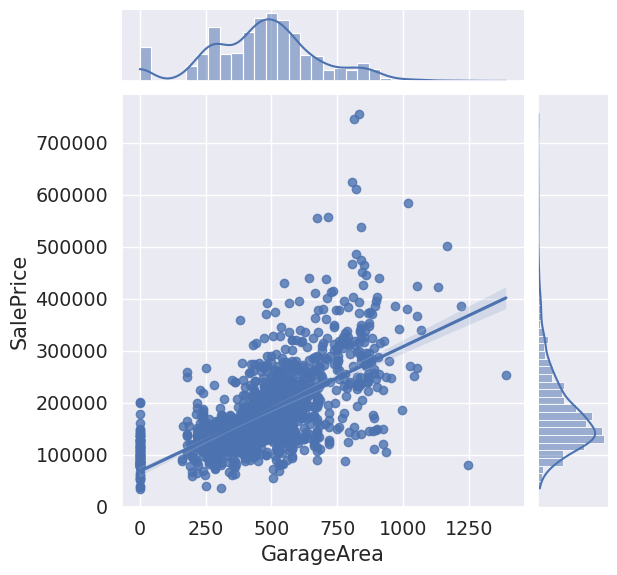

In [396]:
sns.jointplot(x=train_data[corrcol[3]], y=train_data['SalePrice'], kind='reg')

**Есть одно подозрительное значение с большой площадью гаража, но ценой меньше, чем 100.000$. Возможно, предыдущий владелец работал на БелАЗе и хранил его с своем гараже, хотя, как пролетарий, и не был очень богатым. Но тем не менее, это все же выброс.**

In [30]:
print(train_data.shape)
train_data.drop(train_data[(train_data[corrcol[3]]>1000) & (train_data['SalePrice']<200000)].index, inplace=True)
print(train_data.shape)

(1447, 81)
(1446, 81)


14. **Пятый признак: площадь фундамента. Без эксцессов.**

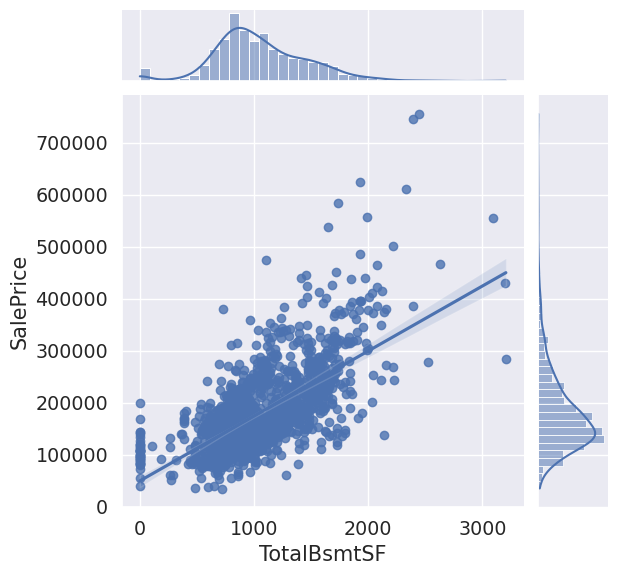

In [404]:
sns.jointplot(x=train_data[corrcol[4]], y=train_data['SalePrice'], kind='reg')

15. **Шестой признак: площадь первого этажа. Все нормально.**

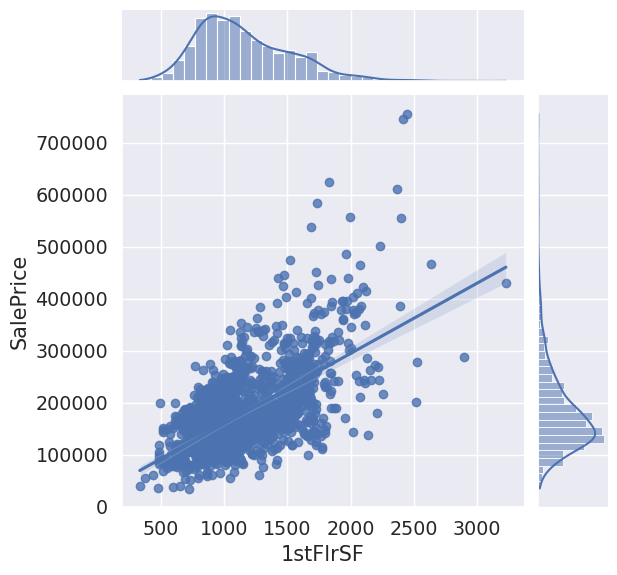

In [409]:
sns.jointplot(x=train_data[corrcol[5]], y=train_data['SalePrice'], kind='reg')

16. **Седьмой признак:количество бассейнов. Без странностей.**

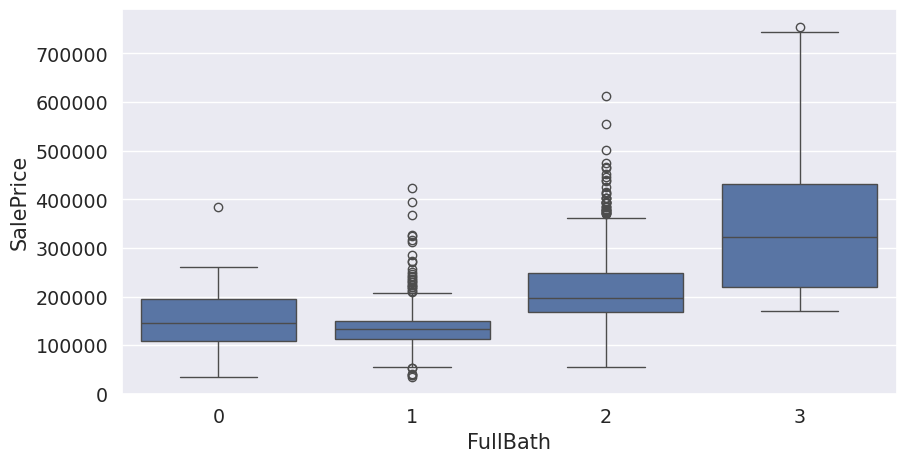

In [412]:
plt.figure(figsize=(10,5))
sns.boxplot(x=train_data[corrcol[6]], y=train_data['SalePrice'])
plt.show()

17. **Восьмой признак: количество комнат.**

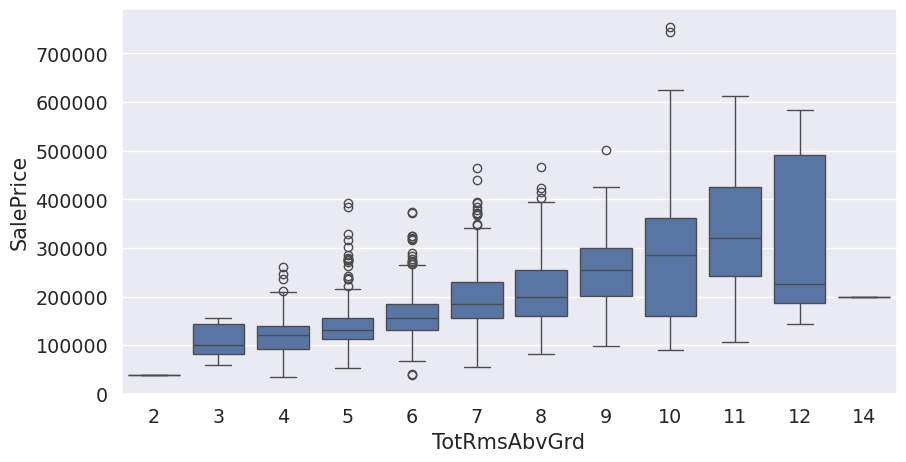

In [416]:
plt.figure(figsize=(10,5))
sns.boxplot(x=train_data[corrcol[7]], y=train_data['SalePrice'])
plt.show()

**Дома с 12 и 14 комнатами слишком дешевые. Возможно здесь жили гномы и небольшую площадь могли поделить на много маленьких комнат. Но все же, предлагаем подвергнуть гномов в рамках данного анализа дискриминации.**

In [32]:
print(train_data.shape)
train_data.drop(train_data[(train_data[corrcol[7]]>11)].index, inplace=True)
print(train_data.shape)

(1446, 81)
(1437, 81)


18. **Девятый признак: дата постройки. Ничего выкидывать здесь не будем.**

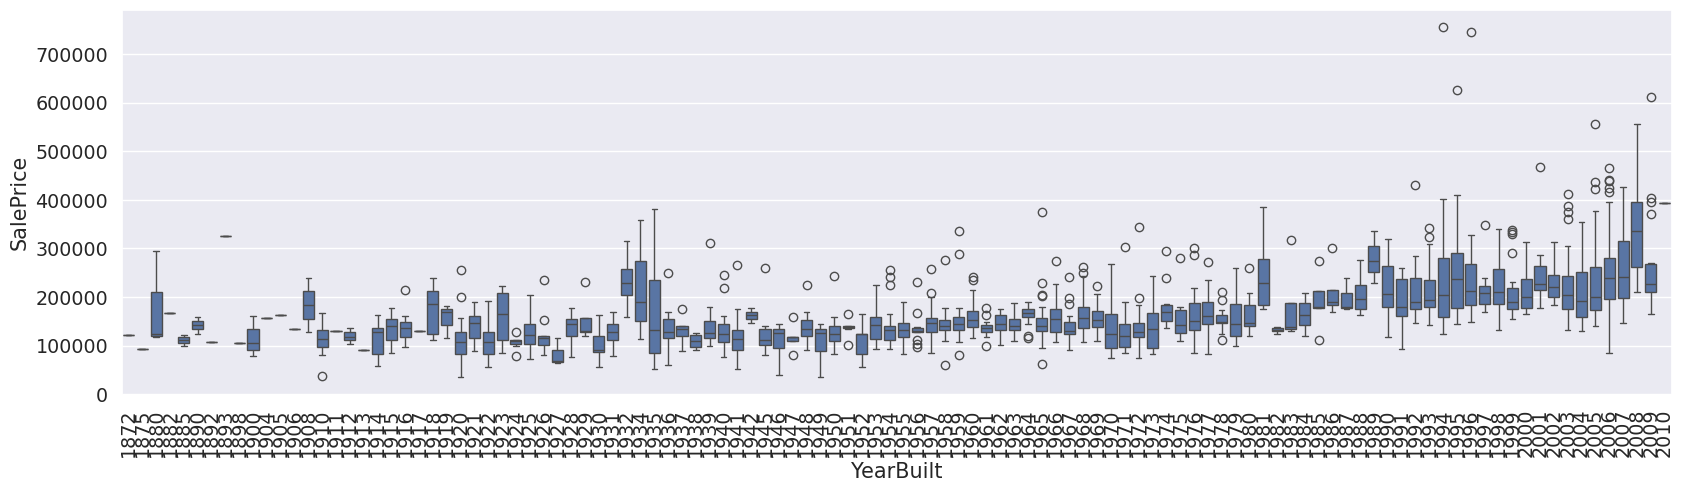

In [427]:
plt.figure(figsize=(20,5))
sns.boxplot(x=train_data[corrcol[8]], y=train_data['SalePrice'])
plt.xticks(rotation=90)
plt.show()

19. **Десятый признак: дата реконструкции. Не трогаем, это на Новый год.**

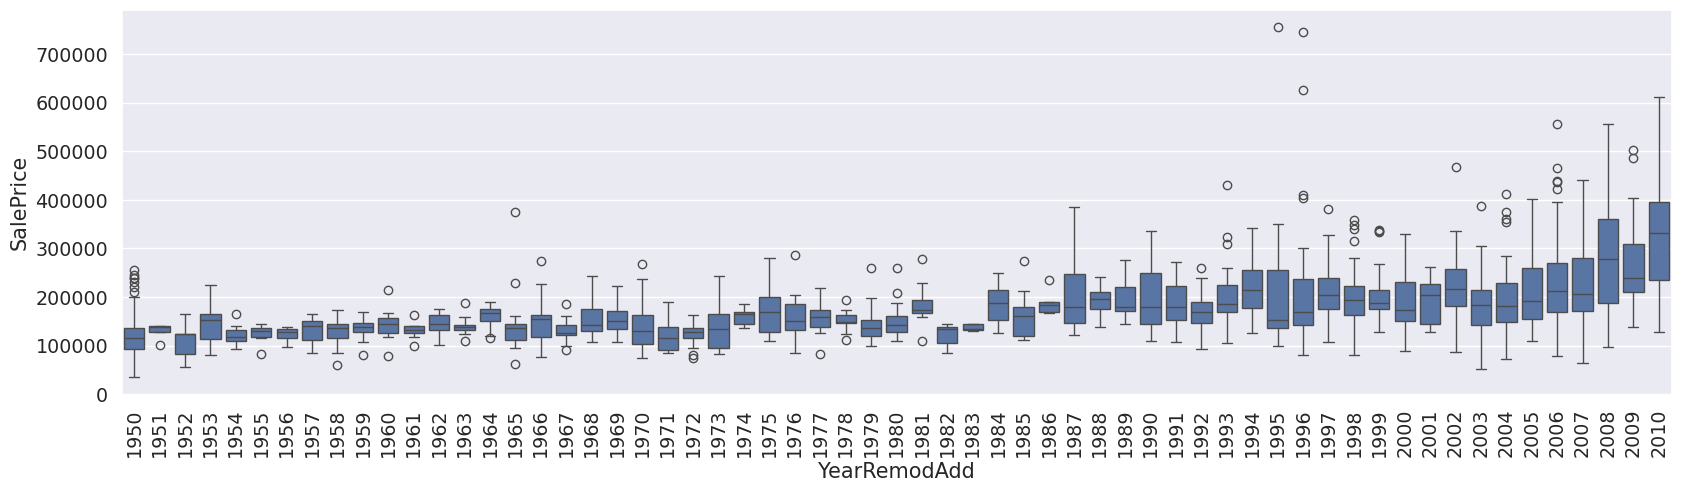

In [241]:
plt.figure(figsize=(20,5))
sns.boxplot(x=train_data[corrcol[9]], y=train_data['SalePrice'])
plt.xticks(rotation=90)
plt.show()

<h2><font color='DarkCyan'>#3 Распределение цен</font><h2>

In [34]:
plt.figure(figsize=(10,5))
sns.histplot(data=pd.DataFrame(target), x='SalePrice', kde=True)
plt.show()

NameError: name 'target' is not defined

<Figure size 1000x500 with 0 Axes>

**Распределение цены далеко не гауссово. И тем не менее, мы не будем исключать значения в правой части гистограммы. Предполагаем, что они не дадут существенные погрешности при прогнозировании низких цен. Кроме того, дорогие дома существуют, и для корректных предсказаний соответствующие образцы нужно сохранить.**

<h2><font color='DarkCyan'>#4 Загрузка тестовой выборки</font><h2>

20. **Загружаем тестовые данные и смотрим, какие данные признаки имеют неизвестные значения.**

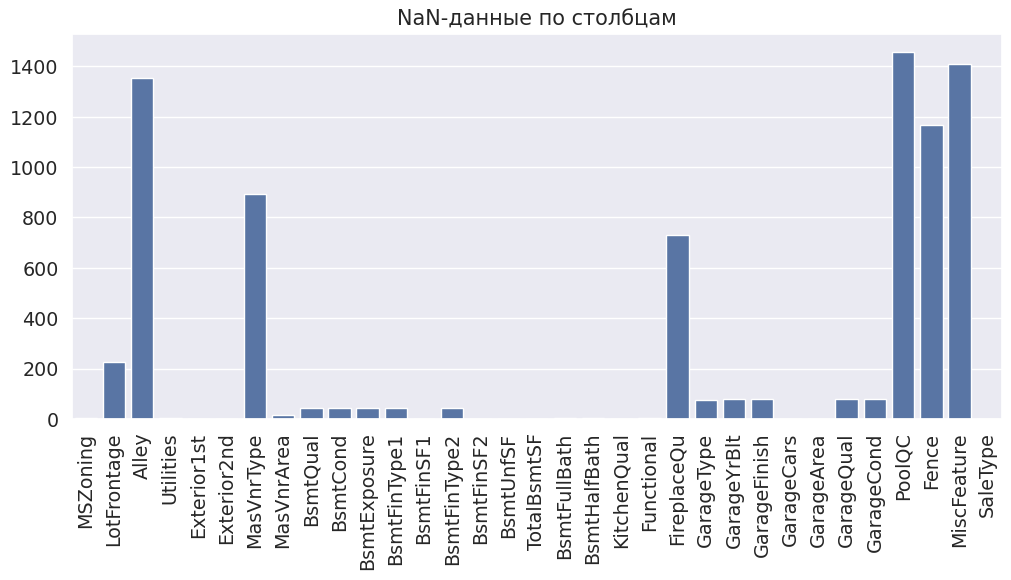

In [36]:
df = pd.read_csv('test.csv')

col_names = df.columns[1:]
nans = []
df_nan = df.isna()
cols = []
for col in col_names:
    howmuch = sum(df_nan[col])
    if (howmuch != 0):
        nans.append(howmuch)
        cols.append(col)

together = dict(zip(cols, nans))
plt.figure(figsize=(12,5))
sns.barplot(data = together)
plt.xticks(rotation=90)
plt.title("NaN-данные по столбцам")
plt.show()

21. **Поступаем аналогично тому, что мы делали в случае пустых данных в тренировочной выборке.**

In [39]:
df["Alley"] = df["Alley"].fillna("NOT")
df["LotFrontage"] = df["LotFrontage"].fillna(df["LotFrontage"].mean())
df["MasVnrType"] = df["MasVnrType"].fillna("NOT")
df["MasVnrArea"] = df["MasVnrArea"].fillna(0)
df["BsmtQual"] = df["BsmtQual"].fillna("NOT")
df["BsmtCond"] = df["BsmtCond"].fillna("NOT")
df["BsmtExposure"] = df["BsmtExposure"].fillna("NOT")
df["BsmtFinType1"] = df["BsmtFinType1"].fillna("NOT")
df["BsmtFinType2"] = df["BsmtFinType2"].fillna("NOT")
df["FireplaceQu"] = df["FireplaceQu"].fillna("NOT")
df["GarageType"] = df["GarageType"].fillna("NOT")
df["GarageYrBlt"] = df["GarageYrBlt"].fillna(df['GarageYrBlt'].mode()[0])
df["GarageFinish"] = df["GarageFinish"].fillna("NOT")
df["GarageQual"] = df["GarageQual"].fillna("NOT")
df["GarageCond"] = df["GarageCond"].fillna("NOT")
df["PoolQC"] = df["PoolQC"].fillna("NOT")
df["Fence"] = df["Fence"].fillna("NOT")
df["MiscFeature"] = df["MiscFeature"].fillna("NOT")
df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
df['Utilities'] = df['Utilities'].fillna(df['Utilities'].mode()[0])
df["BsmtFinSF1"] = df["BsmtFinSF1"].fillna(0)
df["BsmtFinSF2"] = df["BsmtFinSF2"].fillna(0)
df["BsmtUnfSF"] = df["BsmtUnfSF"].fillna(0)
df["TotalBsmtSF"] = df["TotalBsmtSF"].fillna(0)
df["BsmtFullBath"] = df["BsmtFullBath"].fillna(0)
df["BsmtHalfBath"] = df["BsmtHalfBath"].fillna(0)
df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])
df['Functional'] = df['Functional'].fillna(df['Functional'].mode()[0])
df["GarageCars"] = df["GarageCars"].fillna(0)
df["GarageArea"] = df["GarageArea"].fillna(0)
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])

test_data = df
del df
print(test_data.shape)

(1459, 80)


22. **Проверяем, что все хорошо.**

[]


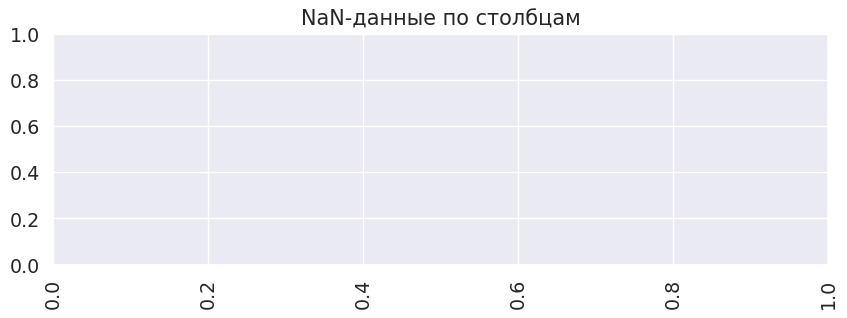

In [41]:
df_nan = test_data.isna()
col_names = test_data.columns[1:]
cols = []
nans = []
for col in col_names:
    howmuch = sum(df_nan[col])
    if (howmuch != 0):
        nans.append(howmuch)
        cols.append(col)

print(cols)
together = dict(zip(cols, nans))
plt.figure(figsize=(10,3))
sns.barplot(data = together)
plt.xticks(rotation=90)
plt.title("NaN-данные по столбцам")
plt.show()

<h2><font color='DarkCyan'>#5 Преобразуем test и train. Удалим несущественные столбцы и преобразуем категориальные признаки</font><h2>

23. **Объединим тренировочные и тестовые данные, выделим целевой вектор. Сразу убеераем столбец "Id", он первый**

In [45]:
target = train_data['SalePrice']
cols_feature = train_data.columns[1:-1]
train_features = train_data.loc[:,cols_feature]
test_features = test_data.loc[:,cols_feature]

Ntrain = train_features.shape[0]
Ntest = test_features.shape[0]
print(train_features.shape, Ntrain)

ВМЕСТЕ = pd.concat((train_features, test_features)).reset_index(drop=True)
print(ВМЕСТЕ.shape)

(1437, 79) 1437
(2896, 79)


24. **Посмотрим на распределение цены в зависимости от некоторых признаков**

* **В зависмости от месяца и года выставления на продажу:**

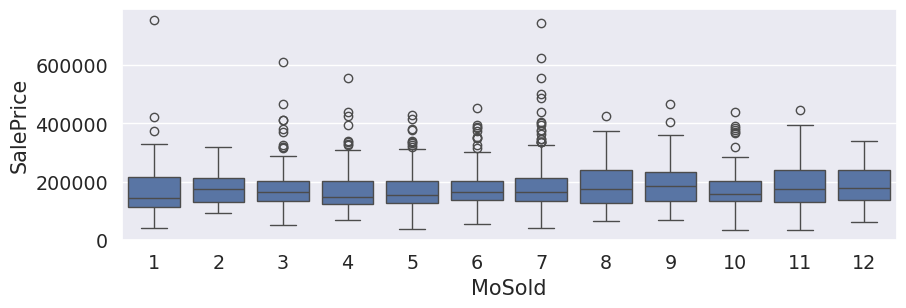

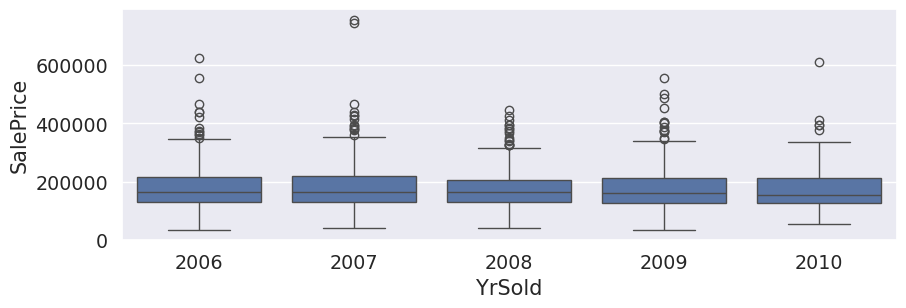

In [462]:
plt.figure(figsize=(10,3))
sns.boxplot(x=train_features['MoSold'], y=target)
plt.show()
plt.figure(figsize=(10,3))
sns.boxplot(x=train_features['YrSold'], y=target)
plt.show()

**Как видно, никакого различия в средних значениях в зависимости от этих характреистик не наблюдается. Удаляем эти столбцы**

In [48]:
try: 
    ВМЕСТЕ.drop(labels='MoSold', inplace=True, axis=1)
except:
    print("Already removed")

try:
    ВМЕСТЕ.drop(labels='YrSold', inplace=True, axis=1)
except:
    print("Already removed")

print(ВМЕСТЕ.shape)

(2896, 77)


* **Качество крыши "RoofMatl"**

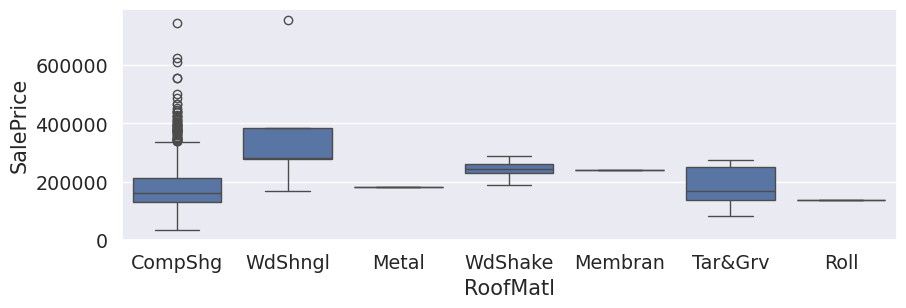

In [469]:
plt.figure(figsize=(10,3))
sns.boxplot(x=train_features['RoofMatl'], y=target)
plt.show()

**Присутствуют единичные экземпляры крыш, отличных от "CompShg", несущественный признак.**

In [50]:
try:
    ВМЕСТЕ.drop(labels='RoofMatl', inplace=True, axis=1)
except:
    print("Already removed")

print(ВМЕСТЕ.shape)

(2896, 76)


* **Категории 'Condition1' и 'Condition2'**

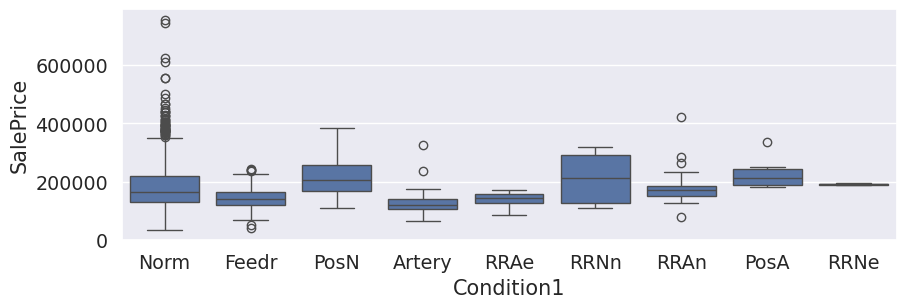

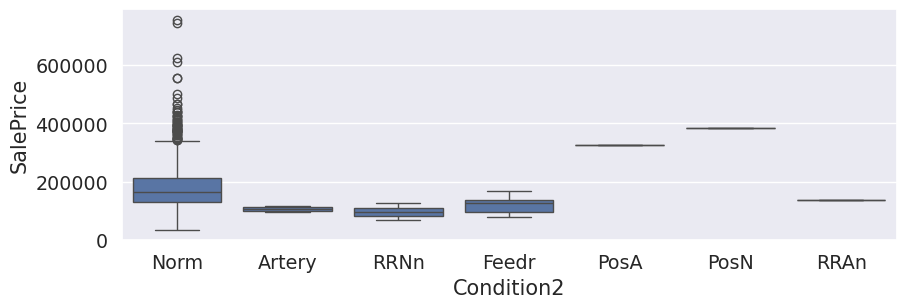

In [475]:
plt.figure(figsize=(10,3))
sns.boxplot(x=train_features['Condition1'], y=target)
plt.show()
plt.figure(figsize=(10,3))
sns.boxplot(x=train_features['Condition2'], y=target)
plt.show()

**Если посмотреть на круговую диаграмму для 'Condition2', то там подавляющее большинство принадлежит к одному типу, для 'Condition1' уже чуть более разнообразное распределение, и тем не менее нет существенных отличий в среднем значении для разных значений этого признака. Удаляем.**

In [52]:
try:
    ВМЕСТЕ.drop(labels='Condition1', inplace=True, axis=1)
except:
    print("Already removed")

try:
    ВМЕСТЕ.drop(labels='Condition2', inplace=True, axis=1)
except:
    print("Already removed")

print(ВМЕСТЕ.shape)

(2896, 74)


26. **Преобразуем категориальные признаки с помощью one-hot**

In [55]:
ВМЕСТЕ = pd.get_dummies(ВМЕСТЕ)
print(ВМЕСТЕ.shape)

(2896, 274)


27. **Наконец, разъединим тестовую и тренировочную выборки и приступим к обучению**

In [58]:
train = ВМЕСТЕ[:Ntrain]
test = ВМЕСТЕ[Ntrain:]

print(train.shape, test.shape)

(1437, 274) (1459, 274)


<h1><font color='DarkBlue'>Применение моделей регрессии</font><h1>

28. **В этом разделе протестируем разные регрессионные модели и выберем наиболее точную из них.**

In [72]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb

29. **Универсальная функция для кросс-валидации разных моделей. Используемая метрика: r2.**

In [65]:
"""метрики: neg_mean_absolute_percentage_error, neg_mean_absolute_error, r2"""

def rmsle_cv(model, x_train=None, y_train=None):
    n_folds = 5
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train.values)
    rmse = cross_val_score(model, x_train.values, y_train, scoring="r2", cv = kf)
    return(rmse)

In [67]:
print("min sale: ", min(target), "  mean: ", target.mean())

min sale:  34900   mean:  180256.14544189282


30. **Будем использовать следующие модели: ElasticNet (линейная регрессия с l1 и l2 регуляризацией), KernelRidge (полиномиальная регрессия), GradientBoostingRegressor (градиентный бустинг), XGBRegressor (другой градиентный бустинг), RandomForestRegressor (случайный лес). Для ElasticNet воспользуемся функцией make_pipeline, которая будет выполнять два шага: нормализация данных с помощью RobustScaler и затем собственно применение модели регрессии. Параметры перебирались вручную, здесь представлены те, которые показали хороший результат (по критерию r2_score > 0.9). Это не касается KernelRidge, она приведена здесь только для того, чтобы продемонстрировать ее некорректность для данного датасета.**

In [70]:
models_names = ['ElasticNet', 'KernelRidge', 'GradientBoostingRegressor', 'XGBRegressor', 'RandomForestRegressor']
results = pd.DataFrame({'Model': models_names, 'r2_score': [0]*len(models_names)})

In [519]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.01, l1_ratio=.3, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=0.5)
GBoost = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.05,
                                   max_depth=2, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=13)
XGB = xgb.XGBRegressor(colsample_bytree=0.2, 
                             learning_rate=0.01, max_depth=2, 
                             n_estimators=2000,
                             reg_alpha=0.5, reg_lambda=0.5,
                             random_state =13)
rfr = RandomForestRegressor(n_estimators=5000, criterion='squared_error', max_depth=10,
                            min_samples_split=5, min_samples_leaf=2, max_features='sqrt', 
                            n_jobs=-1, random_state=13)


models = [ENet, KRR, GBoost, XGB, rfr]

for i in range(len(models)):
    score = rmsle_cv(models[i], x_train=train, y_train=target)
    results.loc[i, "r2_score"] = score.mean()

results

/home/ivantozavr/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=1.05987e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/ivantozavr/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=3.13936e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/ivantozavr/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=1.1655e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/ivantozavr/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=1.12174e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/ivantoz

,Model,r2_score
0,ElasticNet,0.905079
1,KernelRidge,-3.347933
2,GradientBoostingRegressor,0.920735
3,XGBRegressor,0.918006
4,RandomForestRegressor,0.868108


In [108]:
GBoost = GradientBoostingRegressor()
params = {'n_estimators': np.arange(1700, 2200, 100), 'learning_rate': np.arange(0.04, 0.06, 0.01), 'max_depth': np.arange(1, 3, 1),
         'min_samples_leaf': [15], 'min_samples_split': [10], 'loss': ['huber'], 'random_state': [13], 'max_features': ['sqrt']}
gscv = GridSearchCV(GBoost, params, scoring='r2', n_jobs=-1, cv=5)

gscv.fit(train, target)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': array([0.04, 0.05]),
                         'loss': ['huber'], 'max_depth': array([1, 2]),
                         'max_features': ['sqrt'], 'min_samples_leaf': [15],
                         'min_samples_split': [10],
                         'n_estimators': array([1700, 1800, 1900, 2000, 2100]),
                         'random_state': [13]},
             scoring='r2')

In [109]:
gscv.best_params_

{'learning_rate': 0.05,
 'loss': 'huber',
 'max_depth': 2,
 'max_features': 'sqrt',
 'min_samples_leaf': 15,
 'min_samples_split': 10,
 'n_estimators': 2100,
 'random_state': 13}

In [112]:
GBoost = GradientBoostingRegressor(n_estimators=2100, learning_rate=0.05,
                                   max_depth=2, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=13)

score = rmsle_cv(GBoost, x_train=train, y_train=target)
print(score.mean())

0.9206234846169179


In [94]:
XGB = xgb.XGBRegressor()
params = {'n_estimators': np.arange(1500, 2500, 300), 'learning_rate': np.arange(0.03, 0.06, 0.01), 'max_depth': np.arange(1, 3, 1), 
          'colsample_bytree': np.arange(0.2, 0.5, 0.1), 'reg_alpha': [0.5], 'reg_lambda': [0.5], 'random_state': [13]}
gscv = GridSearchCV(XGB, params, scoring='r2', n_jobs=-1, cv=5)

gscv.fit(train, target)
gscv.best_params_

{'colsample_bytree': 0.30000000000000004,
 'learning_rate': 0.05,
 'max_depth': 2,
 'n_estimators': 1800,
 'random_state': 13,
 'reg_alpha': 0.5,
 'reg_lambda': 0.5}

In [96]:
XGB = xgb.XGBRegressor(colsample_bytree=0.3, 
                             learning_rate=0.05, max_depth=2, 
                             n_estimators=1800,
                             reg_alpha=0.5, reg_lambda=0.5,
                             random_state =13)

score = rmsle_cv(XGB, x_train=train, y_train=target)
print(score.mean())

0.922898695360779


In [100]:
rfr = RandomForestRegressor()
params = {'n_estimators': np.arange(3000, 7000, 1000), 'criterion': ['squared_error'], 'max_depth': np.arange(5, 20, 5),
                            'min_samples_split': np.arange(4, 7, 1), 'min_samples_leaf': np.arange(1, 4, 1), 'max_features': ['sqrt'], 
                            'n_jobs': [-1], 'random_state': [13]}

gscv = GridSearchCV(rfr, params, scoring='r2', n_jobs=-1, cv=5)
gscv.fit(train, target)
gscv.best_params_

/home/ivantozavr/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'criterion': 'squared_error',
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 5000,
 'n_jobs': -1,
 'random_state': 13}

In [102]:
rfr = RandomForestRegressor(n_estimators=5000, criterion='squared_error', max_depth=15,
                            min_samples_split=4, min_samples_leaf=1, max_features='sqrt', 
                            n_jobs=-1, random_state=13)

score = rmsle_cv(rfr, x_train=train, y_train=target)
print(score.mean())

0.879245648051711


31. **Наилучшие результаты продемонстрировали GradientBoostingRegressor и XGBRegressor. Фактически, результаты мало отличаются. Так как обе этих модели имели одинаковое количество оценщиков (2.000) и одинаковую небольшую максимальную глубину дерева (2), то мы считаем, что обе этих модели не переобучены. Но остановимся все-таки на градиентном бустинге.**

<h1><font color='DarkBlue'>Применяем на тестовой выборке</font><h1>

In [539]:
GBoost = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.05,
                                   max_depth=2, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=13)
GBoost.fit(train, target)
predict = GBoost.predict(test)

32. **Построим под конец распределение для предсказанных цен, никаких неадекватных значений не получилось. Обратим толькоо внимание на то, что домов с ценой более 600.000$ модель не предсказывает, хотя в тренировочной выборке попадались и такие экземпляры.**

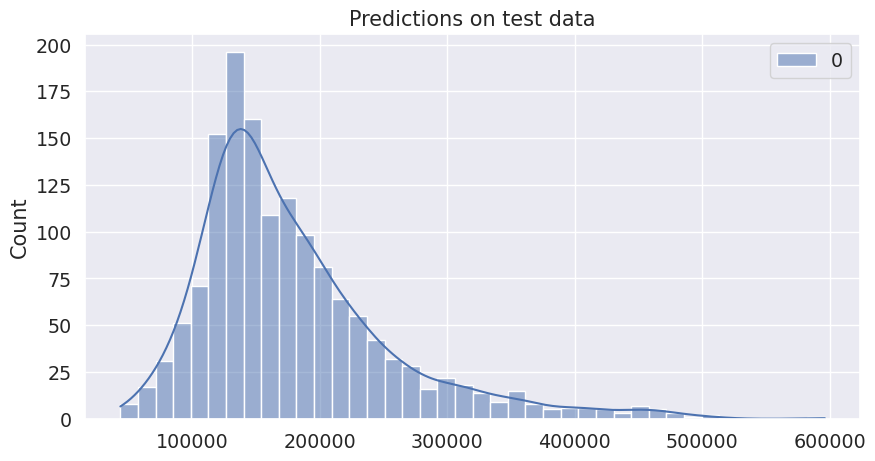

180256.27


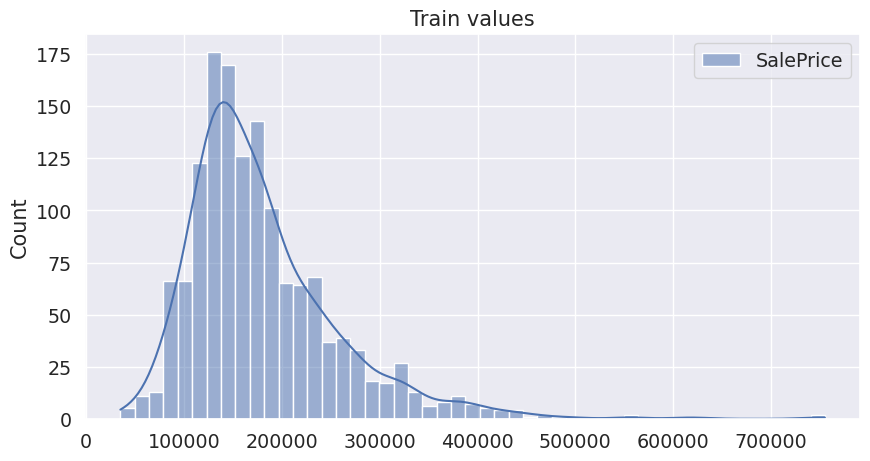

180256.14544189282


In [540]:
plt.figure(figsize=(10,5))
sns.histplot(data=pd.DataFrame(predict), kde=True)
plt.title('Predictions on test data')
plt.show()
print(pred.mean())
plt.figure(figsize=(10,5))
sns.histplot(data=pd.DataFrame(target), kde=True)
plt.title('Train values')
plt.show()
print(target.mean())

33. **Записываем.**

In [621]:
pd.DataFrame({'Id': [i+1 for i in range(predict.shape[0])], 
              'SalePrice': predict}).to_csv('answers.csv', index=False)